# Métodos de clustering

Este documento trata de explorar diferentes técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

Cargamos las siguientes librerías:

In [1]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        
from sklearn import datasets       

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que contiene las etiquetas que identifican a cada cluster.

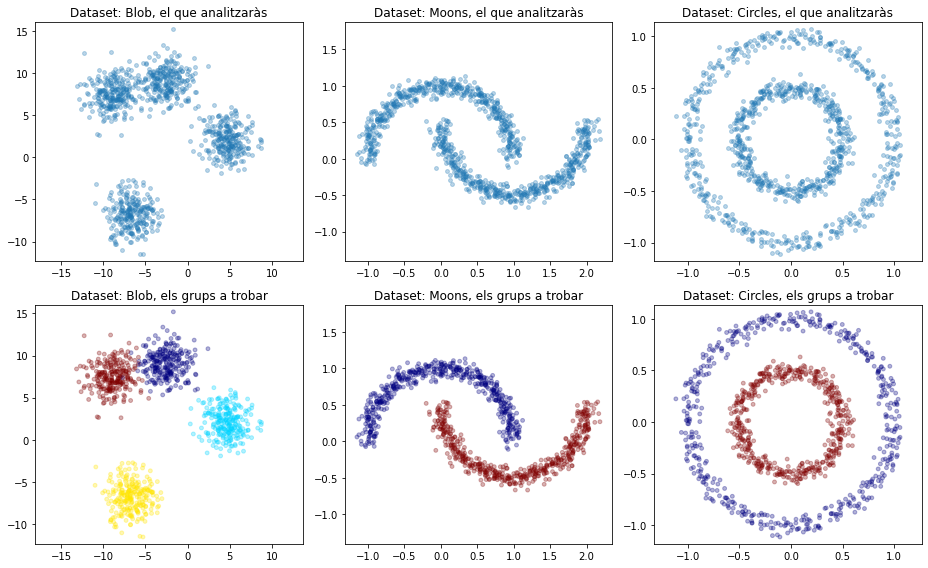

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('el que analitzaràs' if i < 3 else 'els grups a trobar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1. K-means

In [4]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
    <strong>Cálculo y visualización</strong> de la regla del codo en el dataset Blobs.
</div>

Empezaremos creando una función para visualizar la regla del codo que nos sirviera para todos los casos. También daremos la opción de utilizar el método de la silueta si lo necesitamos.

La función está basada en el ejemplo visto en el libro *Mastering Machine Learning with sckit-learn* de Gavin Hackeling.

In [5]:
def calculate_k(X, max_k, method = 'e'):
    
    # Dependiendo de si es un método u otro utilizaremos un determinado rango
    if(method == 'e'):
        K = range(1, max_k)
    elif(method == 's'):
        K = range(2, max_k)
        
    values = []
    # Obtenemos los valores para construir la gráfica, ya sea mediante el método del codo o la silueta
    for k in K:
        kmeans = cluster.KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X)
        if(method == 'e'):
            values.append(kmeans.inertia_)
        elif(method == 's'):
            values.append(silhouette_score(X, kmeans.labels_))
    
    # Visualizamos la gráfica del codo
    plt.plot(K, values, 'bo-')
    plt.xlabel('k')
    plt.ylabel('Average values')
    plt.title('Selecting k')
    plt.show()

C:\Users\Casa\anaconda3\envs\uoc20211pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


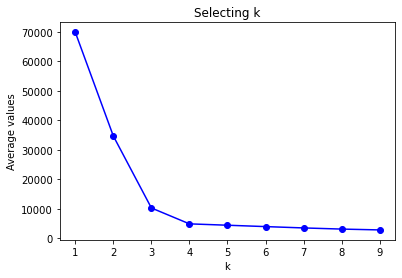

In [6]:
calculate_k(X, 10)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Con esta gráfica podemos escoger como k-óptimo k = 3, puesto que es donde se produce el codo, es decir, el punto a partir del cual la suma de los errores cuadráticos ya no desciende tan rápidamente.

Sabemos que el número de clusters óptimo para este dataset es 4, pero el k obtenido con el método del codo es 3. Con la función que hemos creado podemos comprobar también el k-óptimo con el método de la silueta, aunque es más costes computacionalmente. Para ese dataset no es un problema, pero para datasets mayores si podría serlo.

In [7]:
calculate_k(X, 10, method='s')

Podemos ver que los mejores valores de k son k = 3 y k = 4, con poca diferencia entre ellos. Con los resultados obtenidos de realizar este método podríamos intentar hacer la visualización del dataset con 3 y 4 clusters y escoger el que mejor se adapte a nuestras necesidades.

<div class="alert alert-block alert-info">
<strong>Cálculo y visualización</strong> de los grupos en el dataset Blobs.
</div>

Primero utilizaremos 3 clusters que es el que habíamos obtenido con el método del codo:

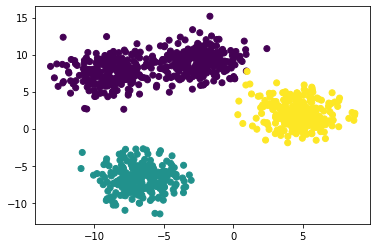

In [8]:
kmeans_3 = cluster.KMeans(n_clusters=3, random_state=123)

# Ajustamos los datos
kmeans_3.fit(X)

# Visualizamos
plt.scatter(X[:,0] , X[:,1] , c = kmeans_3.labels_)
plt.show()

Probamos también de realizar *k-means* con 4 clusters que era el segundo mejor valor de k que habíamos obtenido con el método de la silueta:

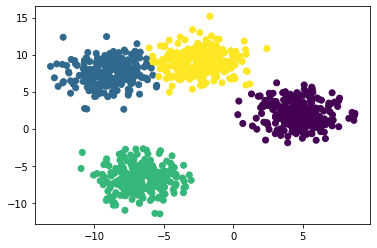

In [9]:
kmeans_4 = cluster.KMeans(n_clusters=4, random_state=123)

kmeans_4.fit(X)

plt.scatter(X[:,0] , X[:,1] , c = kmeans_4.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Con 3 clusters k-means no ha dividido el dataset de la forma que queríamos. Las dos nubes de puntos que están más cerca las ha identificado como un solo grupo. A la hora de calcular los centroides representativos de cada grupo habrá cogido un punto central entre estos dos que será más cercano a los datos que cualquier otro centroide.

Podemos ver estos centros con el atributo *cluster centers*:

In [10]:
kmeans_3.cluster_centers_

array([[-5.74341579,  8.26078132],
       [-6.66491964, -6.77356234],
       [ 4.62510916,  2.11243986]])

Viendo los centroides que ha calculado, podemos ver que el punto -5.74341579, 8.26078132 es el punto al que nos referíamos que está en el centro del que queríamos que fueran 2 clusters distintos.

Por el contrario, con k = 4, tenemos estos puntos:

In [11]:
kmeans_4.cluster_centers_

array([[ 4.66824087,  2.05923467],
       [-8.92932393,  7.4600295 ],
       [-6.66491964, -6.77356234],
       [-2.5274322 ,  9.02841118]])

Aquí sí que se ha creado un centroide para cada uno de los dos clusters que están más juntos.

En ese caso nos quedaríamos con k= 4 que es el que mejor se adapta a lo que queríamos obtener. Si fuera un caso con datos reales correspondientes a algún problema en particular, podríamos analizar los parámetros de los centroides y decidir cuál es la forma que más nos interesa tener los datos agrupados.

Aparte de métodos como el del codo o la silueta, un buen conocimiento del dominio nos ayuda a decidir mejor el número de clusters óptimo para el problema.

In [12]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Cálculo y visualización</strong> de la regla del codo en el dataset Moons.
</div>

In [13]:
calculate_k(X, 10)

C:\Users\Casa\anaconda3\envs\uoc20211pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Analizamos esta otra gráfica tal y como hemos hecho anteriormente. El codo se produce en el punto k = 2, a partir de ese punto el error total disminuye mucho más lentamente al aumentar k.

Para mejorar k podríamos utilizar el método de la silueta o probar con distintas variaciones del método k-means aplicando distintos parámetros como el máximo de iteraciones a realizar o cambiando algoritmo que va a hacer uso. Pero en este caso nos quedaremos con k=2 que es el número óptimo de clusters que queríamos obtener para estos datos.

<div class="alert alert-block alert-info">
<strong>Cálculo y visualización</strong> de los grupos en el dataset Moons.
</div>

In [14]:
kmeans = cluster.KMeans(n_clusters=2, random_state=123)

kmeans.fit(X)

plt.scatter(X[:,0] , X[:,1] , c = kmeans.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Con el método del codo hemos obtenido un k-óptimo que se corresponde con lo que queremos obtener, pero la división que ha hecho k-means no es la correcta. Visualizando los datos en un scatter plot podemos darnos cuenta de que los grupos no sigues unas tendencias circulares, sino que cada uno tiene una distribución distinta en forma de semicírculo. K-means no logra obtener unas agrupaciones adecuadas para estos datos.

K-means obtiene un punto central (centroide) a partir del cual se van agrupando datos y recalculando un nuevo centroide representativo del grupo que será la media de los miembros del grupo. De esta forma lo que hace es crear particiones que tienden a ser circulares, con un punto central por cada clúster y los datos que pertenecen a este grupo alrededor.

Si vemos los centroides comprobaremos que cada grupo está representado por este punto central que hemos explicado:

In [15]:
kmeans.cluster_centers_

array([[-0.21815279,  0.57320973],
       [ 1.18794008, -0.06421299]])

Efectivamente, -0.21815279, 0.57320973 es el punto para el grupo de la izquierda y 1.18794008, -0.06421299 es el centroide para el grupo de la derecha.

En los siguientes apartados probaremos otros métodos, basados en la densidad y jerárquicos, veremos si mejoran el resultado obtenido con k-means.

In [16]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Cálculo y visualización</strong> de la regla del codo en el dataset Circles.
</div>

C:\Users\Casa\anaconda3\envs\uoc20211pec2\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


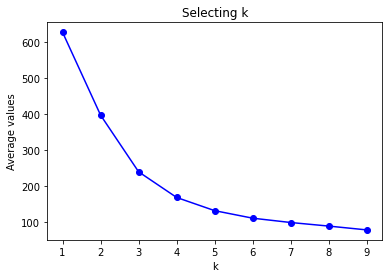

In [17]:
calculate_k(X, 10)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Viendo la gráfica nos quedaremos con un k = 3. No es el k que queremos obtener, así que veamos si el método de la silueta nos aporta algo más de luz.

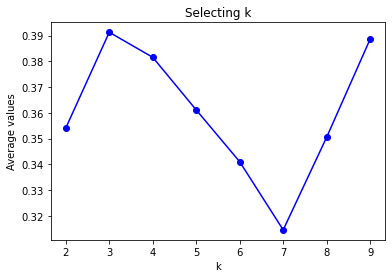

In [18]:
calculate_k(X, 10, method='s')

En este caso no nos pasa como el ejemplo del dataset *blobs* donde teníamos dos k muy parecidos y uno era el que queríamos obtener. En este caso los mejores valores de k son k = 3 y k=9, ninguno de los dos es el que nos interesa.

<div class="alert alert-block alert-info">
<strong>Cálculo y visualización</strong> de los grupos en el dataset Circles.
</div>

Probamos la implementación con k = 3, que está más cerca de los dos grupos que queremos tener:

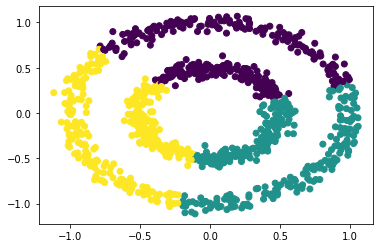

In [19]:
kmeans = cluster.KMeans(n_clusters=3, random_state=123)

kmeans.fit(X)

plt.scatter(X[:,0] , X[:,1] , c = kmeans.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.
</div>

Ha sucedido algo parecido a lo ocurrido en el dataset anterior. K-means agrupa los datos asignándolos al grupo con menor distancia respecto al punto representativo de cada clúster, y así veamos estos tres grupos bien diferenciados. Pero esto no es el resultado que queremos obtener. Queremos dos grupos, uno el círculo exterior y uno interior.

Podemos intentar realizar k-means con k = 2, pero el resultado será muy parecido al obtenido con k = 3.

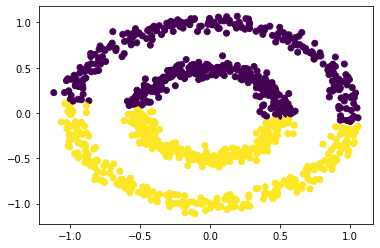

In [20]:
kmeans = cluster.KMeans(n_clusters=2, random_state=123)

kmeans.fit(X)

plt.scatter(X[:,0] , X[:,1] , c = kmeans.labels_)
plt.show()

Como habíamos previsto, k-means minimiza los errores y obtiene dos grupos diferenciados correctamente, pero no de la forma que queremos.

Tal y como nos ha ocurrido con el dataset *moons*, probaremos con métodos basados en otras medidas y veremos si obtenemos mejores resultados.

### 2. Algoritmos basados en densidad: DBScan

En este apartado aplicaremos clustering por densidad, como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN), en los datasets anteriores para detectar los grupos subyacentes.

In [21]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los
parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

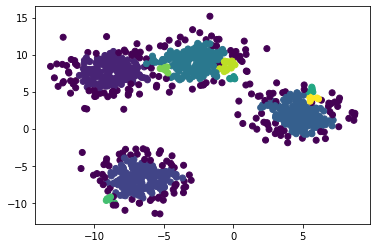

In [22]:
# Ajustamos los datos
clustering = cluster.DBSCAN().fit(X)

# Visualizamos
plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

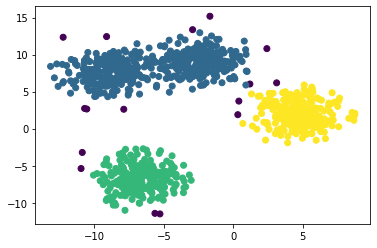

In [23]:
clustering = cluster.DBSCAN(eps=1.2).fit(X)

plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

En primer lugar hemos utilizado DBSCAN con los parámetros por defecto, esto nos ha proporcionado una solución en la que ha identificado muchos datos como valores *outliers* y también ha creado grupos pequeños en lo que deberían ser los 4 grupos principales.

Después de probar con variaciones de los parámetros nos quedamos con eps = 1.2. Con este valor de *eps* hemos obtenido una visualización similar a la obtenida mediante k-means con un valor de k = 3.

DBSCAN funciona bien si los grupos son suficientemente densos y están bien separados entre sí por regiones de baja densidad. En este caso esto puede ser correcto para los clusters inferiores, pero no para el cluster de arriba que nosotros queremos que sean 2 clusters distintos. Están muy juntos y un valor de eps suficiente para que sean dos grupos independientes provocaría que muchos de los otros puntos se consideren outliers o se creen pequeños grupos que no queremos. Tal y como ha ocurrido con la primera visualización con el valor de *eps* por defecto, que es de 0.5.

In [24]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

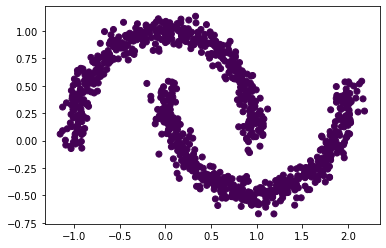

In [25]:
clustering = cluster.DBSCAN().fit(X)

plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

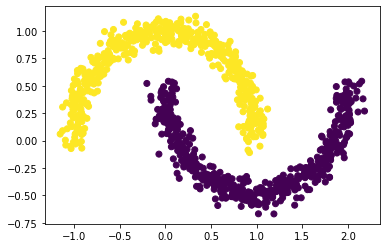

In [26]:
clustering = cluster.DBSCAN(eps=0.2).fit(X)

plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

En una primera implementación del algoritmo con los parámetros por defecto sólo ha detectado un grupo en el que ha localizado todos los datos. Variando el parámetro *eps* a 0.2 podemos ver la división de los datos tal y como queríamos.

Este parámetro indica la distancia máxima entre dos muestras por considerarse miembros del mismo grupo. Ha sido necesario reducir el valor por defecto de 0,5 a 0,2 para ver correctamente los dos grupos diferenciados, ya que los datos están muy próximos entre ellos.

Podemos ver una gran mejora respecto a k-means para estos datos. La distribución que siguen hacen que sea más apropiado aplicar DBSCAN, ya que los grupos son muy densos y existen zonas de baja intensidad, en este caso prácticamente sin datos, que separan ambos grupos.

In [27]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de DBScan jugando con los parámetros
 <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

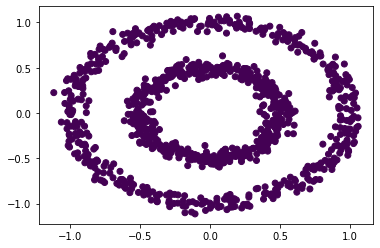

In [28]:
clustering = cluster.DBSCAN().fit(X)

plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

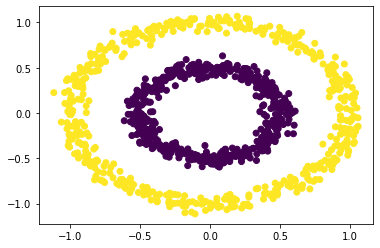

In [29]:
clustering = cluster.DBSCAN(eps=0.2).fit(X)

plt.scatter(X[:,0] , X[:,1] , c = clustering.labels_)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Para el dataset *circles* ha ocurrido algo muy parecido al dataset *moons*. Con los parámetros por defecto no hemos conseguido ver más que un grupo, pero modificando *eps* a 0.2 podemos ver claramente los dos grupos diferenciados tal y como queríamos.

Tanto con este dataset como con el de *moons* podemos comprobar que este algoritmo basado en la densidad es mucho más adecuado para separar sus datos. Por tanto, antes de aplicar un algoritmo u otro, es interesante hacer una previsualización de los datos que tenemos y conocerlos un poco más.

### 3. Algoritmos jerárquicos

Aquí visualizaremos mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*).

In [30]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando diferentes <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
</div>

Utilizaremos los siguientes criterios de enlace:

- Simple (single)
- Completo (completa)
- Medio (average)

**Enlace simple**

In [31]:
# Creamos el dendograma
Z = linkage(X, 'single')

# Visualizamos
dendrogram(
        Z,
        show_leaf_counts=True,  
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  
    )
plt.show()

Si visualizamos el dendrograma de este modo, nos resulta realmente difícil, casi imposible, extraer ninguna información visualmente. Además, el coste computacional es considerable incluso para ese tamaño de datos. Por tanto, truncamos el árbol de la misma manera que se ha hecho en la entrada [*SciPy Hierarchical Clustering and Dendrogram Tutorial*](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/) del blog Jörn's Blog.

Con el modo *lastp* mostraremos sólo las últimas uniones realizadas, en concreto veremos las últimas 10.

Para no repetirnos con los distintos datasets, crearemos una función que visualizará el dendrograma:

In [32]:
def plot_dendogram(data):    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  
        p=10,  
        show_leaf_counts=True,  
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,  
    )
    plt.show()

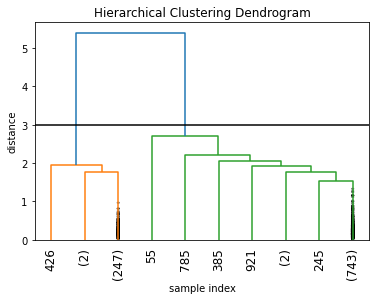

In [33]:
# Hemos añadido la línea a posteriori para diferenciar claramente los clusters que hemos visto
plt.axhline(y=3, c='k')
plot_dendogram(Z)

Ahora sí que podemos ver mejor cómo se van uniendo los datos en distintos grupos. Con el vínculo simple podemos distinguir claramente dos grupos. Siendo el de la derecha mayor. Sabemos que con estos datos lo óptimo son 4 grupos, pero con este dendrograma no podemos distinguirlos claramente.

Creamos una pequeña función que creará y visualizará los clusters a partir del dendrograma y un valor de k:

In [34]:
def calculate_plot_clusters(dendogram, k):
    clusters = fcluster(dendogram, k, criterion='maxclust')
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:,0], X[:,1], c=clusters)
    plt.show()

Calculamos y visualizamos los clusters con k = 2:

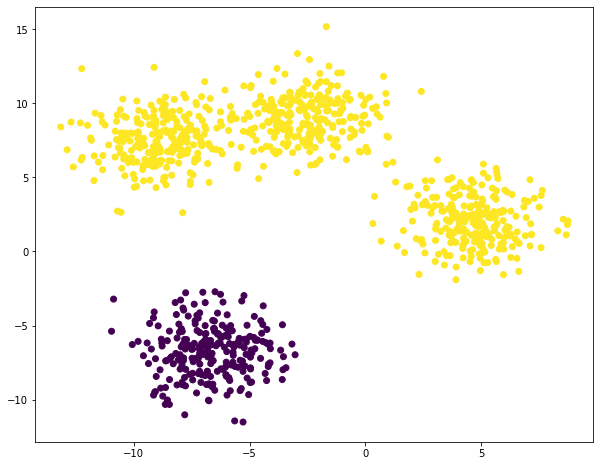

In [35]:
calculate_plot_clusters(Z, 2)

**Enlace completo**

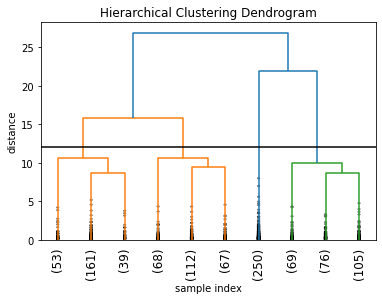

In [36]:
Z = linkage(X, 'complete')

plt.axhline(y=12, c='k')
plot_dendogram(Z)

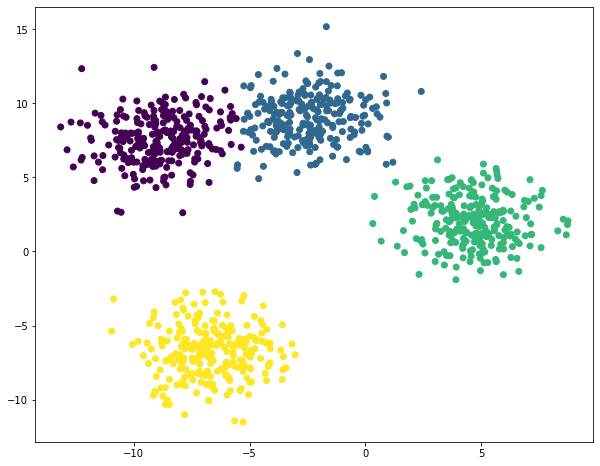

In [37]:
calculate_plot_clusters(Z, 4)

**Enlace medio**

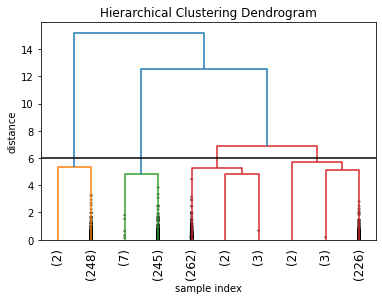

In [38]:
Z = linkage(X, 'average')

plt.axhline(y=6, c='k')
plot_dendogram(Z)

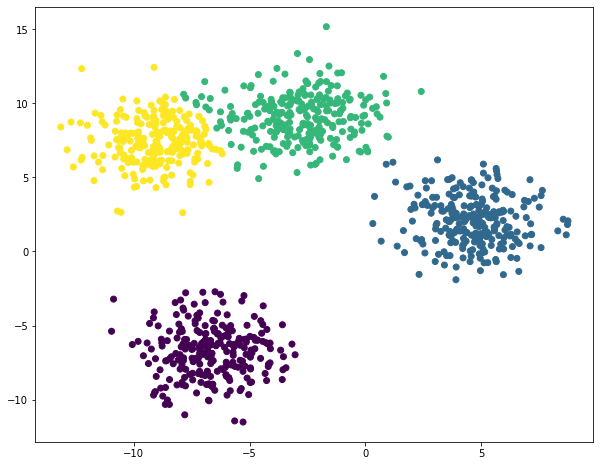

In [39]:
calculate_plot_clusters(Z, 4)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

El enlace con el que peor resultado hemos obtenido ha sido con el enlace simple.

Con este enlace hemos visto que podíamos dividir claramente los datos en dos clusters. Esto se aleja bastante de los resultados obtenidos con k-means y con DBSCAN, siendo la peor opción. Este resultado poco acertado puede deberse a que el enlace simple es más sensible al ruido y presenta el problema del efecto cadena. Este efecto puede hacer que dos grupos distintos aparezcan unidos como un solo grupo porque comparten algún elemento cercano. Si vemos los tres grupos que ha identificado como uno, tienen algún punto cercano siempre entre ellos, pero no así con el otro grupo que ha encontrado, el cual sí está más separado del resto.

Por lo que respecta al enlace completo y medio, hemos obtenido un resultante bastante mejor. El enlace completo es más sensible a valores *outliers* y como hemos visto cuando hemos aplicado DBSCAN, hay algunos puntos que podrían considerarse como *outliers*. De ahí que veamos una pequeña diferencia entre los grupos calculados con el enlace completo y medio. De todas formas, los dos criterios de enlace presentan los datos bastante bien separados en los 4 grupos. Dependiendo de lo que queremos elegiríamos uno u otro, habría que evaluarlos según los que más nos interese.

In [40]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando diferentes <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br></div>

**Enlace simple**

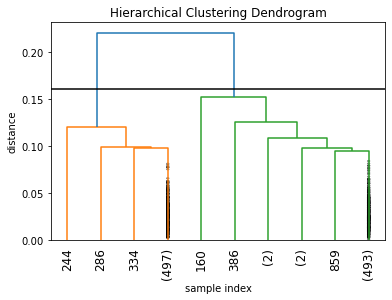

In [41]:
Z = linkage(X, 'single')

plt.axhline(y=0.16, c='k')
plot_dendogram(Z)

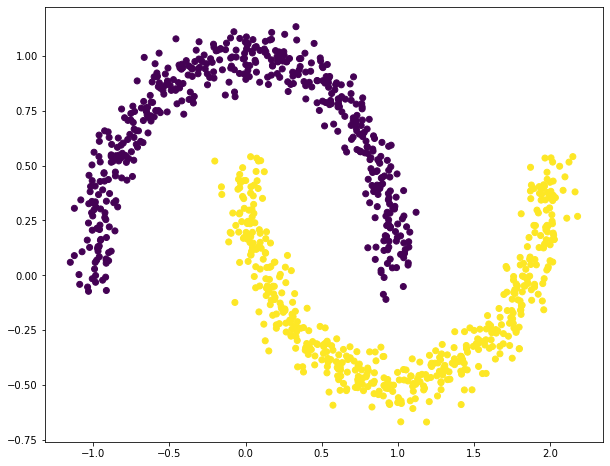

In [42]:
calculate_plot_clusters(Z, 2)

**Enlace completo**

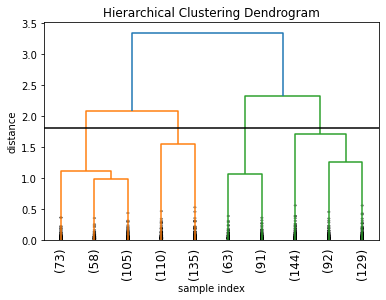

In [43]:
Z = linkage(X, 'complete')

plt.axhline(y=1.8, c='k')
plot_dendogram(Z)

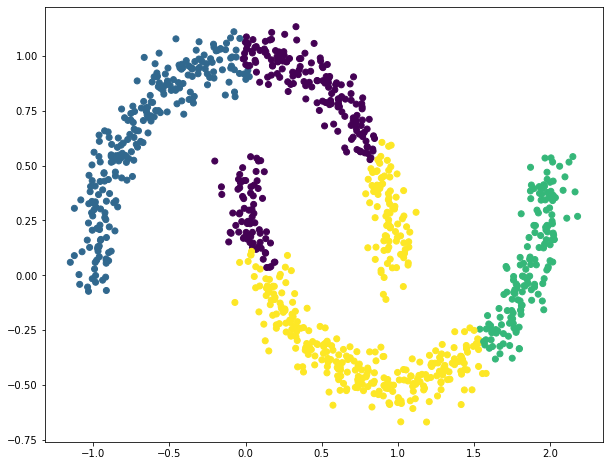

In [44]:
calculate_plot_clusters(Z, 4)

**Enlace medio**

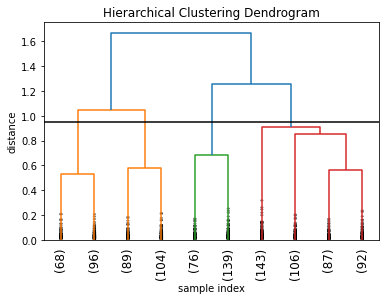

In [45]:
Z = linkage(X, 'average')

plt.axhline(y=0.95, c='k')
plot_dendogram(Z)

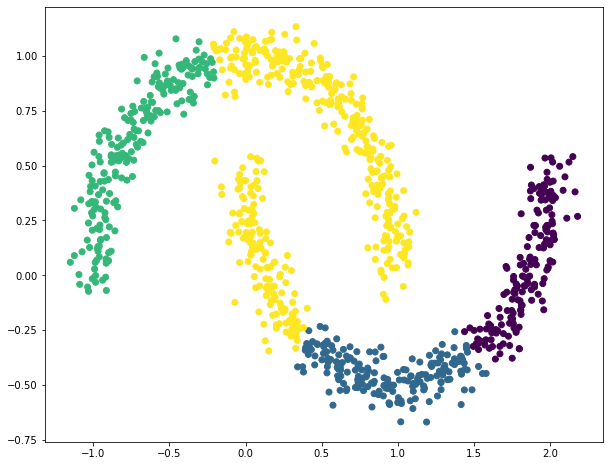

In [46]:
calculate_plot_clusters(Z, 4)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

En este caso, el mejor resultado se ha obtenido con el enlace simple. También podemos distinguir dos clusters si utilizamos el enlace completo y medio, pero siguiendo el mismo criterio que hemos seguido con los datos del dataset *blobs*, hemos visto más coherente elegir los 4 clusters que quedan más separados en el dendrograma. Con k = 4 obtenemos unos valores parecidos a lo que habíamos obtenido con k-means.

Este hecho puede deberse a la manera en que se calcula la distancia dependiendo del criterio de enlace que se utiliza. Vemos las características de cada criterio de enlace:

- Enlace simple: distancia más corta entre un par de observaciones de dos grupos. Puede producir agrupaciones donde distintos puntos de distintos clusters estén más cerca que dos puntos del mismo cluster. Un hecho que ocurre con los datos del dataset *moons*.

- Enlace completo: distancia entre el par de observaciones más lejanas de dos grupos. Produce agrupaciones más compactas que con el vínculo simple.

- Enlace medio: distancia media entre los datos de dos grupos distintos. También proporciona clústeres más compactos. Es más resistente a valores *outliers* que el vínculo completo.

Con estas definiciones podemos ver que lo más adecuado para este conjunto de datos es el enlace simple, porque con la distribución que siguen los datos que tenemos puede producirse el caso en el que dos puntos de datos de grupos distintos estén más cerca que dos puntos de datos de un mismo grupo y esto no sería un error. Por el contrario, grupos tan compactos como los proporcionados por los enlaces completo y medio sí que nos da un resultado que no es lo que queremos.

In [47]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación</strong> de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando diferentes <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
</div>

**Enlace simple**

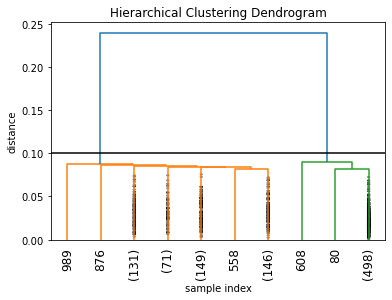

In [48]:
Z = linkage(X, 'single')

plt.axhline(y=0.10, c='k')
plot_dendogram(Z)

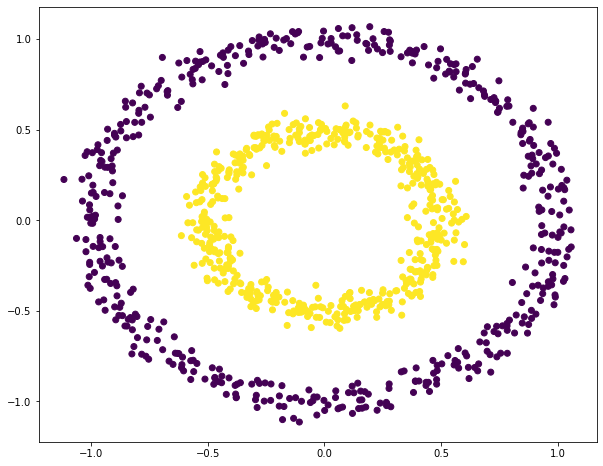

In [49]:
calculate_plot_clusters(Z, 2)

**Enlace completo**

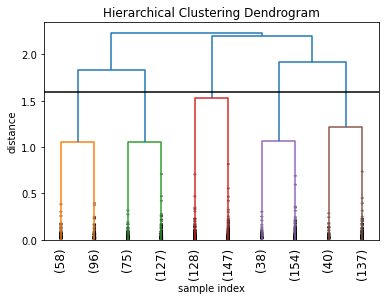

In [50]:
Z = linkage(X, 'complete')

plt.axhline(y=1.6, c='k')
plot_dendogram(Z)

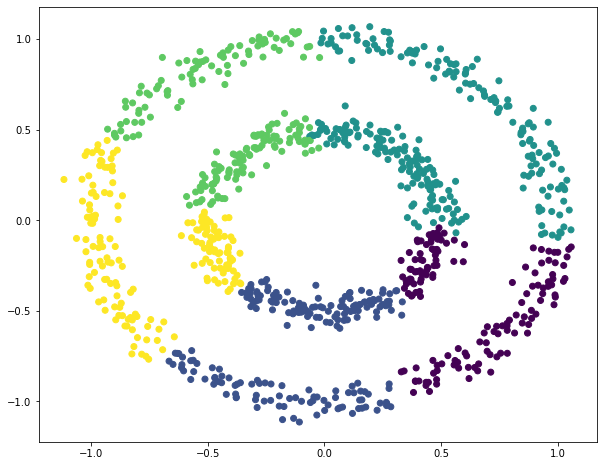

In [51]:
calculate_plot_clusters(Z, 5)

**Enlace medio**

In [52]:
Z = linkage(X, 'average')

plt.axhline(y=0.9, c='k')
plot_dendogram(Z)

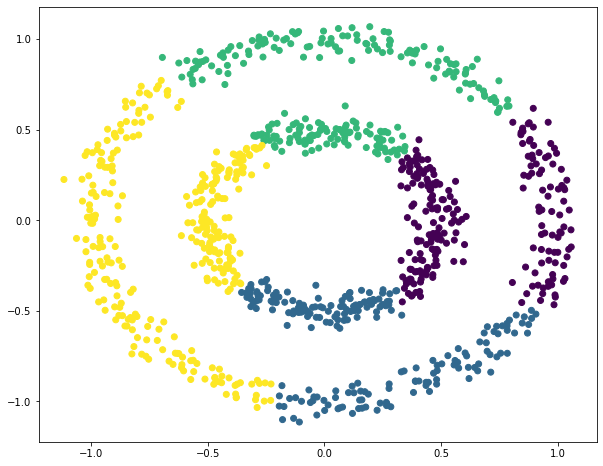

In [53]:
calculate_plot_clusters(Z, 4)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
</div>

Como hemos visto tanto en k-means como en DBSCAN, en el dataset *moons* y en el dataset *circle* nos suele suceder algo parecido.

El vínculo simple es el que mejor resultado nos da para este conjunto de datos. Los criterios completo y medio nos dan unos resultados que podrían parecerse al obtenido con k-means, aunque hemos obtenido un mayor número de clústeres.

Este hecho, como hemos visto con el dataset *moons*, podría deberse al modo en que cada tipo de enlace calcula la distancia.

### Conclusiones

En este documento hemos abordado distintos métodos de agrupamiento a partir de los datos de los datasets *blobs*, *moons* y *circles*.

En concreto, hemos analizado los métodos:

- K-means
- DBSCAN
- Clustering jerárquico

Hemos aplicado estos métodos sobre cada conjunto y hemos visto qué tipo de clustering se agrupa mejor en cada tipo de datos, cuál tiene un coste computacional mayor o menor y las distintas variaciones que podemos realizar con los parámetros que nos proporcionan las funciones de sklearn.